# Exploratory Data Analysis: preprocessing, data cleansing, statistical analysis and visualizations

### 1. import the necessary libraries for the analysis

In [28]:
# public libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# own libraries
from evaluation_framework import LogRegModel

### 2. load data files and merge them into one DataFrame

In [29]:
# read college player statistics from 2009 to 2022
# the data can be found in two different csv files, one contains stats from 2009 to 2021
# while the other one contains the latest statistics (2022)
college1 = pd.read_csv('Data\CollegeBasketballPlayers2009-2021.csv',low_memory=False)
college2 = pd.read_csv('Data\CollegeBasketballPlayers2022.csv',low_memory=False)

# the other data source contains draft picks at the nba draft for each year from 2009 to 2021
draft = pd.read_excel('Data\DraftedPlayers2009-2021.xlsx')

# first of all, lets concatenate the college statistical dataframes
college = pd.concat([college1,college2])
print(college1.size+college2.size == college.size)

# since the draft data set has merged cells in the table header the first row must be dropped
draft.drop(0,axis=0,inplace=True)

# rename the ROUND.1 column to PICK, and modify the PLAYER to player_name 
# so it can be act as a key during the join with the college data set
draft.rename(
    columns={
        "PLAYER": "player_name", 
        "TEAM": "drafted_by", 
        "YEAR" : "year", 
        "ROUND" : "draft_round", 
        "ROUND.1" : "draft_pick"},
        inplace=True)

# also lower all column names
draft.columns = draft.columns.str.lower()

# join (merge) the college set with the draft data to identify those players who have been drafted after playing in college
df = pd.merge(college,draft,how='left',on=['player_name','year'])

True


### 3. clean the data set and prepare it for statistical analyzis and further analytical steps

In [30]:
# create a new column to identify the drafted players
df['drafted_flag'] = (~df.overall.isnull())*1

# since the draft data does not contain information about 2022
# rows for 2022 are removed from the 'df' data set and saved into a new dataframe
df_2022 = df[df.year == 2022]
df = df[df.year < 2022]


# rename unnamed column 64 for clearity and drop unknown or dupplicated columns
df.rename({'Unnamed: 64':'player_position'},inplace=True)
df = df.drop('Unnamed: 65',axis=1)
df = df.drop('pick',axis=1)

# handle missing values
df.drafted_flag.fillna(value=0,inplace=True)

# check non integer columns and encode the categorical values 
# df.select_dtypes(include=['int64','float']).head()

# separate predictors from the target feature
X = df.loc[:-1]
y = df.drafted_flag

# check data for the drafted_flag column
print(df.groupby(['year','drafted_flag'])['drafted_flag'].count())

year  drafted_flag
2009  0               4542
      1                 47
2010  0               4645
      1                 53
2011  0               4502
      1                 46
2012  0               4535
      1                 51
2013  0               4566
      1                 42
2014  0               4679
      1                 43
2015  0               4681
      1                 43
2016  0               4656
      1                 41
2017  0               4695
      1                 48
2018  0               4661
      1                 42
2019  0               4692
      1                 48
2020  0               4685
      1                 48
2021  0               4920
      1                 50
Name: drafted_flag, dtype: int64


### 4. create visualizations and analyze statistics

year
2009    0.010242
2010    0.011281
2011    0.010114
2012    0.011121
2013    0.009115
2014    0.009106
2015    0.009102
2016    0.008729
2017    0.010120
2018    0.008930
2019    0.010127
2020    0.010142
2021    0.010060
dtype: float64


<AxesSubplot: xlabel='drafted_flag', ylabel='Count'>

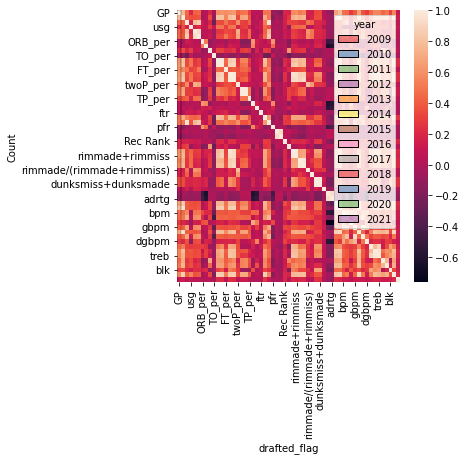

In [31]:
# basic statistics
# print(df.describe())
# print(df.pick.value_counts())

# correlation matrix
corr_matrix = df.corr()
corr_matrix = corr_matrix[abs(corr_matrix) < 1]
corr_matrix = corr_matrix.stack().reset_index()
corr_matrix.columns = ['Variable1','Variable2','Correlation']
# print(corr_matrix)

# empirical distribution of the target feature
drafted_per_year = df[df.drafted_flag == 1].groupby('year').count()['drafted_flag']
count_per_year = df.groupby('year').count()['player_name']
yearly_drafts = drafted_per_year/count_per_year
print(yearly_drafts)

# plot settings
plt.rcParams['figure.figsize']=(5,5)

# heatmap of the correlations
sns.heatmap(df.corr(),annot=False)

# histogram of the target feature
sns.histplot(data=df, x="drafted_flag", hue="year",palette="Set1")

# sns.pairplot(df, x_vars='draft_pick',y_vars=df.select_dtypes(include=['int64','float']).iloc[:,:-1],diag_kind = 'kde')

In [32]:
df.drafted_flag.value_counts()

0    60459
1      602
Name: drafted_flag, dtype: int64

In [33]:
# corr_matrix = corr_matrix[abs(corr_matrix) < 1]
# corr_matrix = corr_matrix.rename_axis(None).rename_axis(None, axis=1)
print(corr_matrix[corr_matrix.Variable1 == 'drafted_flag'].sort_values(by='Correlation',ascending=False).head())

         Variable1            Variable2  Correlation
3158  drafted_flag               porpag     0.250765
3171  drafted_flag            dunksmade     0.238017
3172  drafted_flag  dunksmiss+dunksmade     0.234652
3176  drafted_flag              dporpag     0.221722
3149  drafted_flag                twoPM     0.219013


### 5. Random model creation

In [67]:
# use the empirical distribution of the drafted flag feature to create a random model predicting the drafted players (Bernoulli distribution)
from scipy.stats import bernoulli

# probability of drafted flag = 1
prob_drafted = np.average(yearly_drafts)

# random model with the given Bernoulli distribution with the length of
rand_model = pd.DataFrame(data=[bernoulli(prob_drafted).rvs(len(df))])
rand_model = rand_model.transpose()
rand_model.columns = ['pred_drafted_flag']

print(rand_model.value_counts())

pred_drafted_flag
0                    60432
1                      629
dtype: int64


### 6. Random model evaluation

In [71]:
# evaluate the random model
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_pred=rand_model.pred_drafted_flag, y_true=y)
cp = classification_report(y_pred=rand_model.pred_drafted_flag, y_true=y)
print(cp)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     60459
           1       0.01      0.01      0.01       602

    accuracy                           0.98     61061
   macro avg       0.50      0.50      0.50     61061
weighted avg       0.98      0.98      0.98     61061

